## Decision Trees and Random Forest

In this notebook we will use one more basic ml model &ndash; decision trees and their ensemble &ndash; Random Forest.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, root_mean_squared_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn import tree

## Data load

In [ ]:
data = pd.read_csv("data/train_without_nans.csv")
data_sub = pd.read_csv("data/test_without_nans.csv")

encoded = pd.read_csv("data/encoded_train.csv")
encoded_sub = pd.read_csv("data/encoded_test.csv")

scaled = pd.read_csv("data/scaled_train.csv")
scaled_sub = pd.read_csv("data/scaled_test.csv")

reduced = pd.read_csv("data/pca50train.csv")
reduced_sub = pd.read_csv("data/pca50test.csv")

In [ ]:
scaled_X, scaled_y = scaled.drop("SalePrice", axis=1), scaled["SalePrice"]
reduced_X, reduced_y = reduced.drop("SalePrice", axis=1), reduced["SalePrice"]

## Content

<ol>
    <li><a href="#decision-trees">Decision Trees</a>
        <ul>
            <li><a href="#dt-feature-importance">Feature importance</a></li>
            <li><a href="#dt-cross-validation">Parameters tuning</a></li>
            <li><a href="#dt-residuals">Residuals checking</a></li>
        <ul>
    </li>
    <li><a href="#random-forest">Random Forest</a>
        <ul>
            <li><a href="#rf-cross-validation">Parameters tuning</a></li>
            <li><a href="#rf-residuals">Residuals checking</a></li>
            <li><a href="#rf-final">Final Training and submission</a></li>
        <ul>
    </li>
    <li><a href="#pca-random-forest">Random Forest + PCA</a>
        <ul>
            <li><a href="#pca-rf-cross-validation">Parameters tuning</a></li>
            <li><a href="#pca-rf-residuals">Residuals checking</a></li>
            <li><a href="#pca-rf-final">Final Training and submission</a></li>
        <ul>
    </li>
</ol>

<a id="decision-trees"></a>
### Decision Trees

First of all we can use a simpl decision tree to see how a simple "building block" of the random forest can solve our task

<a id="dt-feature-importance"></a>
### Feature importance

Let's overfit our decision tree to see which features are used by DT to make most of the splits

In [ ]:
dt_overfitted_reg = DecisionTreeRegressor(random_state=1)
dt_overfitted_reg.fit(scaled_X, scaled_y)

feat_importances = pd.DataFrame({"importance": dt_overfitted_reg.feature_importances_}).set_index(scaled_X.columns)
feat_importances.sort_values(by="importance", ascending=False).head(n=5)

A simple decision tree makes almost all of the splits along OverallQual feature. It means that splitting along that feature gives us the most increase in informativity in almost 60% of cases.

There are many features which have feature importance less than 0.01

In [ ]:
feat_importances[feat_importances["importance"] < 0.01].shape

Let's take all features with importances bigger or equal than 0.01 

In [ ]:
dt_selected_features = feat_importances[feat_importances["importance"] >= 0.01].index.values

dt_selected_X = scaled_X[dt_selected_features]
dt_selected_y = scaled_y

<a id="dt-cross-validation"></a>
## Parameters Tuning

Now we can check which decision tree hyperparameters give us the best cross validation score on our data.

For a single decision tree we can bruteforce many combination of parameters for a pretty normal time. For example for the Random Forest it takes much more time.

In [ ]:
parameters = {"max_depth": [i for i in range(2, 20)],
              "min_samples_leaf": [i for i in range(1, 20)],
              "random_state": [1]}

dt_grid = GridSearchCV(DecisionTreeRegressor(), parameters, cv=5,
                       scoring="neg_root_mean_squared_error")
dt_grid.fit(dt_selected_X, dt_selected_y)
print("BEST DT PARAMS:", dt_grid.best_params_)

In [ ]:
print("BEST DT CROSSVAL SCORE:", -dt_grid.best_score_)

That's a pretty poor score. And there is nothing strange about this because a single decision tree is a very weak model.

In [ ]:
dt_selected_reg = DecisionTreeRegressor(max_depth=11, min_samples_leaf=8, random_state=1).fit(dt_selected_X, dt_selected_y)

In [ ]:
print("DT TRAIN ERROR", root_mean_squared_error(dt_selected_y, dt_selected_reg.predict(dt_selected_X)))

Even on train set our decision tree gives us almost the same result as the Ridge Regression on the cross validation

<a id="dt-residuals"></a>

### Residuals Checking 

We will not make a submission with a single decision tree but we can look how its residuals are distributed with respect to the model predictions

In [ ]:
dt_residuals = dt_selected_y - dt_selected_reg.predict(dt_selected_X)
dt_residuals = pd.DataFrame({"residuals": dt_residuals})
plt.figure(figsize=(12, 4))
plt.hist(dt_residuals["residuals"], bins=75)
plt.show()

If we recall our plot for residuals after the Ridge regression we can undestand that the simple decision tree has a bigger variance of the error. 

<a id="random-forest"></a>
## Random Forest

Now let's take a look at how the ensemble of weak Decision Trees can solve our problem. Generally ensemble models are axactly the ones who can be used to decrease the variance of the error of the single model.

In [ ]:
rf_overfitted_reg = RandomForestRegressor(random_state=1)
rf_overfitted_reg.fit(scaled_X, scaled_y)

rf_feat_importances = pd.DataFrame({"importance": rf_overfitted_reg.feature_importances_}).set_index(scaled_X.columns)
rf_feat_importances.sort_values(by="importance", ascending=False).head(n=10)

We have almost the same list of top-affecting features.

In [ ]:
rf_feat_importances[rf_feat_importances["importance"] < 0.005].shape

In [ ]:
rf_selected_features = rf_feat_importances[rf_feat_importances["importance"] >= 0.005].index.values

rf_selected_X = scaled_X[rf_selected_features]
rf_selected_y = scaled_y

<a id="rf-cross-validation"></a>
## Parameters Tuning

If we use too many combinations of parameters we will wait too long for our cross validation so we will tune only **max_depth** parameter to see how our Random Forest performs on our data at least nearly.

In [ ]:
parameters = {"max_depth": [i for i in range(1, 35)],
              "random_state": [1]}

rf_grid = GridSearchCV(RandomForestRegressor(), parameters, cv=5,
                       scoring="neg_root_mean_squared_error")
rf_grid.fit(rf_selected_X, rf_selected_y)
print("BEST RF PARAMS:", rf_grid.best_params_)

In [ ]:
print("BEST RF CROSSVAL SCORE:", -rf_grid.best_score_)

Random Forest gave us much better cross validation scores than a single decision tree. But if we check once again our file with linear models we can see that ridge regression gave us better validation score. Yes, we've used LOOCV during the ridge regression training and not k-fold with k=5 validation but even now we can say that probably decision trees and Random Forest cannot solve our task so good as linear model with regularization.

But of course first of all we need to check the performance of our Random Forest Regressor after we remove objects which give us large residuals. If there are some outliers with respect to the target variable they can badly afect our model.

In [ ]:
rf_selected_reg = RandomForestRegressor(max_depth=15, random_state=1).fit(rf_selected_X, rf_selected_y)

In [ ]:
print("RF TRAIN ERROR", root_mean_squared_error(rf_selected_y, rf_selected_reg.predict(rf_selected_X)))

That's an unbelievable good score but only on the train set. I don't think we will have the same result on the validation set.

<a id="rf-residuals"></a>

### Residuals Checking 

In [ ]:
rf_residuals = rf_selected_y - rf_selected_reg.predict(rf_selected_X)
rf_residuals = pd.DataFrame({"residuals": rf_residuals})
plt.figure(figsize=(12, 4))
plt.hist(rf_residuals["residuals"], bins=75)
plt.show()

Here we also have some objects which give us some big residuals with respect to other objects. As well we saw it with linear models.
Let's delete objects with residual higher than 0.15

In [ ]:
rf_residuals[(rf_residuals["residuals"].abs() > 0.15)].shape[0]

<a id="rf-final"></a>

### Final training and submission

In [ ]:
objects2clear_idx = rf_selected_X[rf_residuals["residuals"].abs() > 0.15].index

print("IDX OF OBJECTS TO DELETE:", objects2clear_idx)

rf_final_X = rf_selected_X.copy().drop(objects2clear_idx)
rf_final_y = rf_selected_y.copy().drop(objects2clear_idx)

print(rf_final_X.shape)

rf_final_reg = RandomForestRegressor(max_depth=15, random_state=1)

cv_scores = cross_val_score(rf_final_reg, rf_final_X, rf_final_y,
                           cv=5, scoring="neg_root_mean_squared_error")

print("FINAL RF CROSSVAL SCORE", -(cv_scores.sum() / 5))

rf_final_reg = rf_final_reg.fit(rf_final_X, rf_final_y)

print("FINAL RF TRAIN ERROR", root_mean_squared_error(rf_final_y, rf_final_reg.predict(rf_final_X)))

In [ ]:
rf_final_residuals = rf_final_y - rf_final_reg.predict(rf_final_X)

In [ ]:
plt.figure(figsize=(12, 4))
plt.scatter(rf_final_reg.predict(rf_final_X), rf_final_residuals)

Let's try to submit our results

In [ ]:
rf_sub_X = scaled_sub[rf_selected_features]

rf_sub_prediction = np.exp(rf_final_reg.predict(rf_sub_X))

rf_sub_df = pd.DataFrame({"Id": data_sub["Id"], "SalePrice": rf_sub_prediction})
rf_sub_df.to_csv("models/RandomForest/rf_sub.csv", index=False)

Unfortunately after feature selection, outliers removing and max_depth parameter bruteforcing we received even worse result than just with a baseline overfitted RandomForest. Even the fact than CV score was nearly 0.12 we receive validation score 0.15

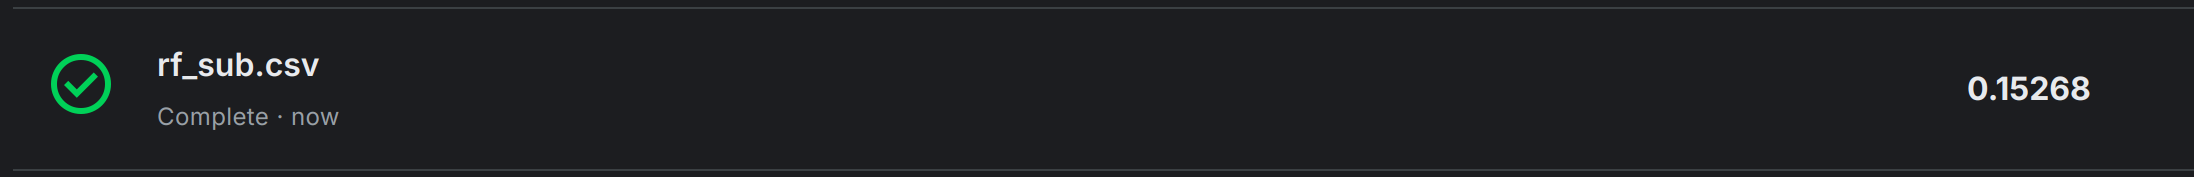

Generally we can accept that Random Forest cannot normally solve our problem on the initial encoded and scaled data. Ridge regression gave us better result.

It means that in our dataset there are no good splitting along the features which can split our dataset into some groups with nearly the same prices.

<a id="pca-random-forest"></a>
## Random Forest + PCA

Let's try to use our Random Forest along the PCA coordinates. As we said the problem of poor performance of our Random Forest above can appear because in initial feature space there are no obvious splitting which give us good increase in informativity.

On the other hand PCA is a method which transform our data so in new feature space we have the largest possible variance along each feature. Perhaps in new features there are some good splitting for DT's and RF.

In [ ]:
pca_rf_overfitted_reg = RandomForestRegressor(random_state=1)
pca_rf_overfitted_reg.fit(reduced_X, reduced_y)

pca_rf_feat_importances = pd.DataFrame({"importance": pca_rf_overfitted_reg.feature_importances_}).set_index(reduced_X.columns)
pca_rf_feat_importances.sort_values(by="importance", ascending=False).head(n=10)

Almost all splitting are made exactly along the first principal component. This is the component with the highest correlation with the target variable. 

In [ ]:
pca_rf_selected_features = pca_rf_feat_importances[pca_rf_feat_importances["importance"] >= 0.005].index.values

pca_rf_selected_X = reduced_X[pca_rf_selected_features]
pca_rf_selected_y = reduced_y

<a id="pca-rf-cross-validation"></a>
### Parameter tuning

In [ ]:
parameters = {"max_depth": [i for i in range(1, 35)],
              "random_state": [1]}

pca_rf_grid = GridSearchCV(RandomForestRegressor(), parameters, cv=5,
                       scoring="neg_root_mean_squared_error")
pca_rf_grid.fit(pca_rf_selected_X, pca_rf_selected_y)
print("BEST PCA RF PARAMS:", pca_rf_grid.best_params_)

In [ ]:
print("BEST PCA RF CROSSVAL SCORE:", -pca_rf_grid.best_score_)

This CV score is a little bit better than CV score after feature selection using Random Forest without PCA

In [ ]:
pca_rf_selected_reg = RandomForestRegressor(max_depth=12, random_state=1).fit(pca_rf_selected_X, pca_rf_selected_y)
print("PCA RF TRAIN ERROR", root_mean_squared_error(rf_selected_y, rf_selected_reg.predict(rf_selected_X)))

<a id="pca-rf-residuals"></a>

### Residuals Checking 

In [ ]:
pca_rf_residuals = pca_rf_selected_y - pca_rf_selected_reg.predict(pca_rf_selected_X)
pca_rf_residuals = pd.DataFrame({"residuals": pca_rf_residuals})
plt.figure(figsize=(12, 4))
plt.hist(pca_rf_residuals["residuals"], bins=75)
plt.show()

In [ ]:
pca_rf_residuals[(pca_rf_residuals["residuals"].abs() > 0.2)].shape[0]

<a id="pca-rf-final"></a>

### Final training and submission

In [ ]:
objects2clear_idx = pca_rf_selected_X[pca_rf_residuals["residuals"].abs() > 0.2].index

print("IDX OF OBJECTS TO DELETE:", objects2clear_idx)

pca_rf_final_X = pca_rf_selected_X.copy().drop(objects2clear_idx)
pca_rf_final_y = pca_rf_selected_y.copy().drop(objects2clear_idx)

print(pca_rf_final_X.shape)

pca_rf_final_reg = RandomForestRegressor(max_depth=12, random_state=1)

cv_scores = cross_val_score(pca_rf_final_reg, pca_rf_final_X, pca_rf_final_y,
                           cv=5, scoring="neg_root_mean_squared_error")

print("FINAL RF CROSSVAL SCORE", -(cv_scores.sum() / 5))

pca_rf_final_reg = pca_rf_final_reg.fit(pca_rf_final_X, pca_rf_final_y)

print("FINAL RF TRAIN ERROR", root_mean_squared_error(pca_rf_final_y, pca_rf_final_reg.predict(pca_rf_final_X)))

In [ ]:
pca_rf_sub_X = reduced_sub[pca_rf_selected_features]

pca_rf_sub_prediction = np.exp(pca_rf_final_reg.predict(pca_rf_sub_X))

pca_rf_sub_df = pd.DataFrame({"Id": data_sub["Id"], "SalePrice": pca_rf_sub_prediction})
pca_rf_sub_df.to_csv("models/RandomForest/pca_rf_sub.csv", index=False)

Using PCA transformation did not make our predictions better 

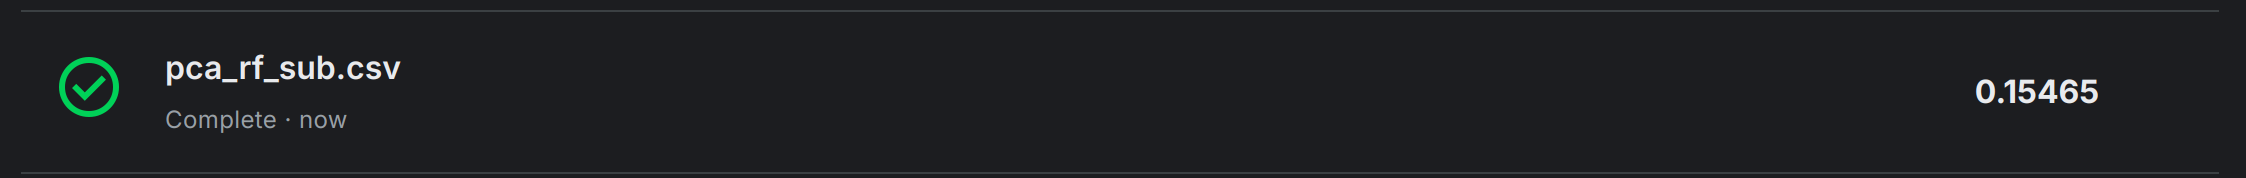

### Conclusions 

What can we learn from this notebook? Here we can understand that Modeling approach using Random Forest on initinal features or PCA features cannot lead us to some brilliant or even better than before prediction results. The reason can be simple that there are no good splits in our data in those features.

What can we do? We can either do some futher research with our features to try to make them more informative for our Random Forest or just try to use some other models.

For now our best public score is still using Ridge regression.